# <h1><b><I> General Setup

In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


In [2]:
lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)
lonmeshrecon, latmeshrecon = np.meshgrid(spatialaxis, spatialaxis)

logjacobtrue = makelogjacob(log10eaxistrue)    

In [3]:
numberoftruevaluesamples = int(5e2)
Nsamples=numberoftruevaluesamples
truelambda = 0.2
nsig = int(round(truelambda*Nsamples))
nbkg = int(round((1-truelambda)*Nsamples))

truelogmassval = -0.5

In [4]:
psfnorm_lonrecon_mesh, psfnorm_lontrue_mesh = np.meshgrid(spatialaxis,spatialaxistrue)

unnormedpsfvals = psf(np.array([psfnorm_lonrecon_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), np.array([psfnorm_lontrue_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), psfnorm_lonrecon_mesh.flatten()*0).reshape(psfnorm_lonrecon_mesh.shape)

/Users/lpin0002/Desktop/DMPipe/utils3d.py:90: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


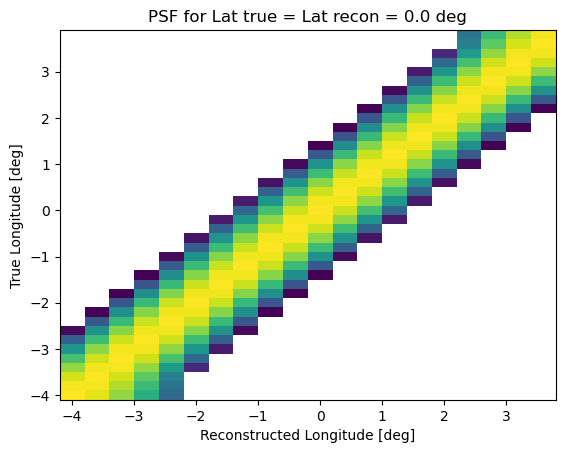

In [5]:
plt.figure()
plt.pcolormesh(spatialaxis, spatialaxistrue, unnormedpsfvals)
plt.xlabel("Reconstructed Longitude [deg]")
plt.ylabel("True Longitude [deg]")
plt.title("PSF for Lat true = Lat recon = 0.0 deg")
plt.show()

# <h1><b>Simulation

## Setup

### Background setup

In [6]:
logbkgpriorvalues = np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue))

logbkgpriorvalues = logbkgpriorvalues - special.logsumexp(logbkgpriorvalues.T+logjacobtrue)

logbkgpriorvalues.shape

/Users/lpin0002/Desktop/DMPipe/utils3d.py:162: RuntimeWarning: divide by zero encountered in log
  return np.log(bkgfull.evaluate(energy=10**logeval*u.TeV, fov_lon=np.abs(lon)*2*u.deg, fov_lat=np.abs(lat)*2*u.deg).value)


(140, 40, 40)

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/91927266.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/91927266.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


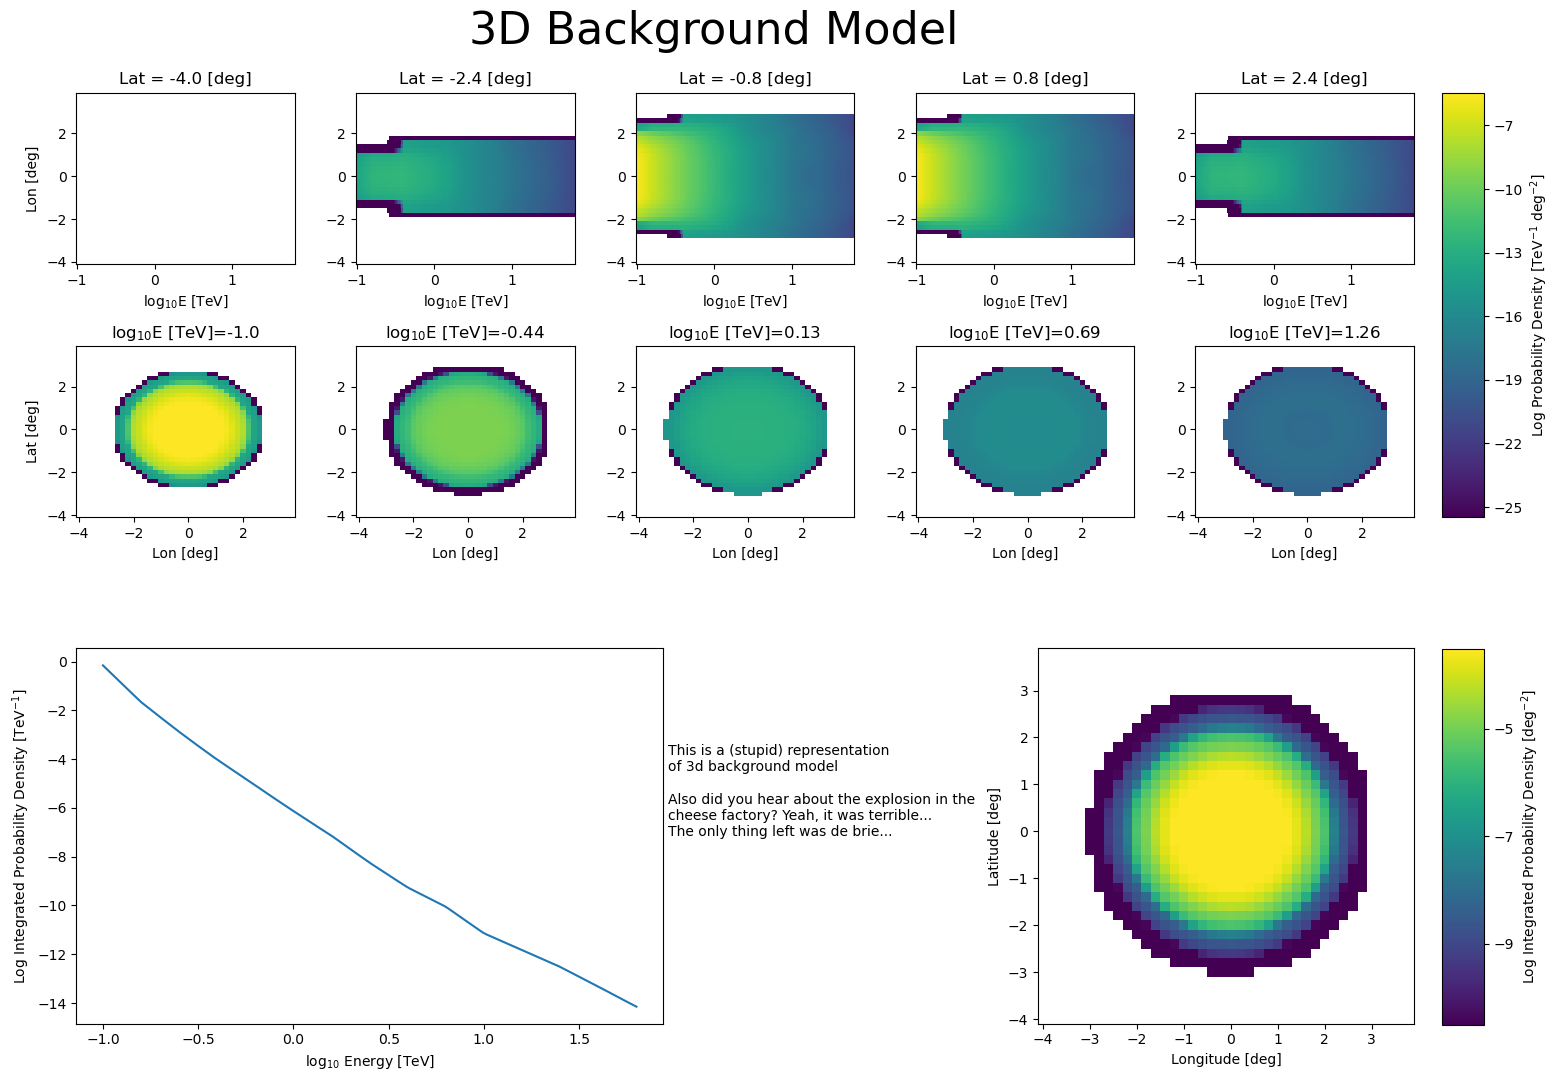

In [7]:
fig,axs = plt.subplots(4,5, figsize=(14,10))


maxval = np.max(logbkgpriorvalues)


spaceconverter = int(np.round(spatialaxistrue.shape[0]/5))
axs[0,0].pcolormesh(log10eaxistrue, spatialaxistrue, logbkgpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(5):
    axs[0,index].pcolormesh(log10eaxistrue, spatialaxistrue, logbkgpriorvalues[:,:,index*spaceconverter].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(spatialaxistrue[index*spaceconverter],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = int(np.round(log10eaxistrue.shape[0]/5))
axs[1,0].pcolormesh(spatialaxistrue, spatialaxistrue, logbkgpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[0*logeconverter],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,5):
    pcol = axs[1,jndex].pcolormesh(spatialaxistrue, spatialaxistrue, logbkgpriorvalues[jndex*logeconverter,:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[jndex*logeconverter],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues,axis=(1,2)))
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logbkgpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(spatialaxistrue, spatialaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20),np.round(maxval), 3))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 2))


plt.suptitle('3D Background Model', y=1.05, size=32)
# fig.tight_layout(pad=5.0)
plt.show()

### Signal Setup

In [8]:
signalspecfunc = darkmatterdoubleinput
signalfunc = setup_full_fake_signal_dist(truelogmassval, signalspecfunc)

In [9]:
log10emeshtrue.shape

(140, 40, 40)

In [10]:
logsigpriorvalues = signalfunc(log10emeshtrue, lonmeshtrue,latmeshtrue)

print(logsigpriorvalues.shape)

logsigpriorvalues = (logsigpriorvalues - special.logsumexp(logsigpriorvalues.T+logjacobtrue))
logsigpriorvalues.shape

(140, 40, 40)


/Users/lpin0002/Desktop/DMPipe/BFCalc/createspectragrids.py:108: RuntimeWarning: divide by zero encountered in log
  return np.log(twodinterpolationfunc(logmDM, logenergy-logmDM))


(140, 40, 40)

In [11]:
lonmeshtrue[:,0,0]

array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.])

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/4136198310.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/4136198310.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,14,22)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/4136198310.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


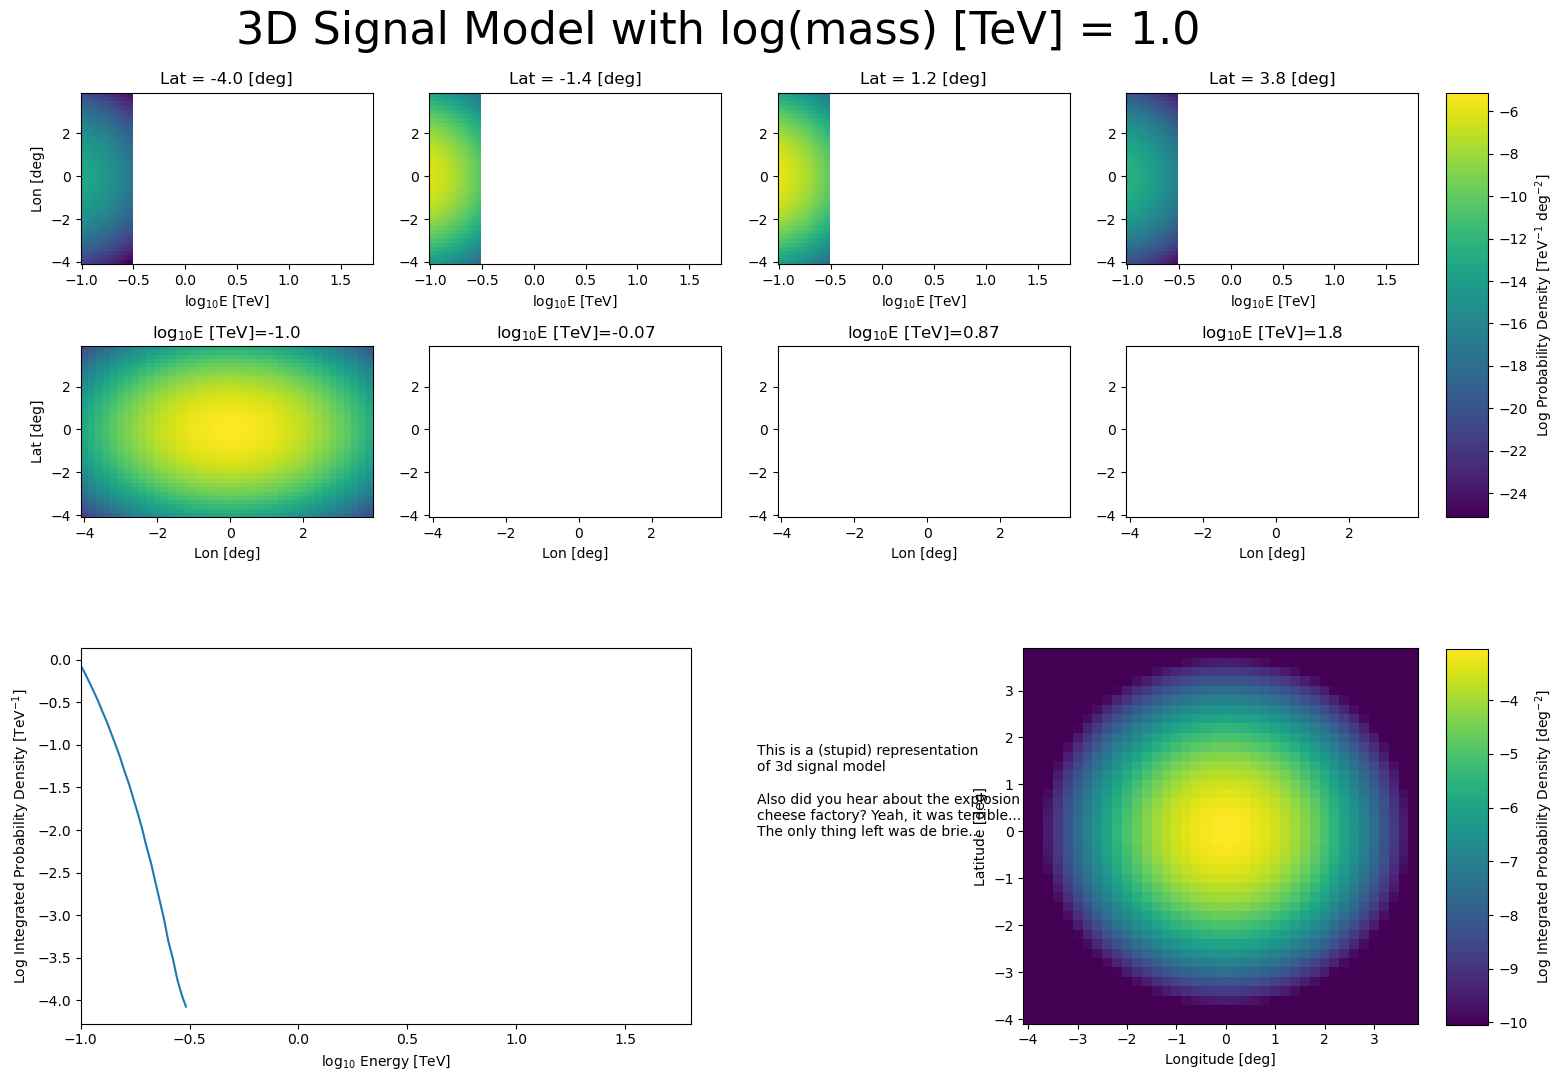

In [12]:
numslices = 4
fig,axs = plt.subplots(4,numslices, figsize=(14,10))


maxval = np.max(logsigpriorvalues)

spaceconverter = np.round(np.linspace(0, spatialaxistrue.shape[0]-1,numslices))


axs[0,0].pcolormesh(log10eaxistrue, spatialaxistrue, logsigpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(numslices):
    axs[0,index].pcolormesh(log10eaxistrue, spatialaxistrue, logsigpriorvalues[:,:,int(spaceconverter[index])].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(spatialaxistrue[int(spaceconverter[index])],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = np.round(np.linspace(0, log10eaxistrue.shape[0]-1,numslices))

axs[1,0].pcolormesh(spatialaxistrue, spatialaxistrue, logsigpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[0])],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,numslices):
    pcol = axs[1,jndex].pcolormesh(spatialaxistrue, spatialaxistrue, logsigpriorvalues[int(logeconverter[jndex]),:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[jndex])],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logsigpriorvalues,axis=(1,2)))
plt.xlim([log10eaxistrue[0],log10eaxistrue[-1]])
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,14,22)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d signal model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logsigpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(spatialaxistrue, spatialaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20)-1,np.round(maxval)+1, 2))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
plt.suptitle('3D Signal Model with log(mass) [TeV] = 1.0', y=1.05, size=32)

# fig.tight_layout(pad=5.0)
plt.show()

## True Value Simulation

In [13]:
logsigbinnedprior = (logsigpriorvalues.T+logjacobtrue).T
flattened_logsigbinnedprior = logsigbinnedprior.flatten()


logbkgbinnedprior = (logbkgpriorvalues.T+logjacobtrue).T
flattened_logbkgbinnedprior = logbkgbinnedprior.flatten()

In [14]:
sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_logsigbinnedprior, Nsamples=nsig),logsigbinnedprior.shape)
siglogevals = log10eaxistrue[sigresultindices[0]]
siglonvals = spatialaxistrue[sigresultindices[1]]
siglatvals = spatialaxistrue[sigresultindices[2]]

-0.5
(140,)


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/1114643582.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/1114643582.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/1114643582.py:38: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


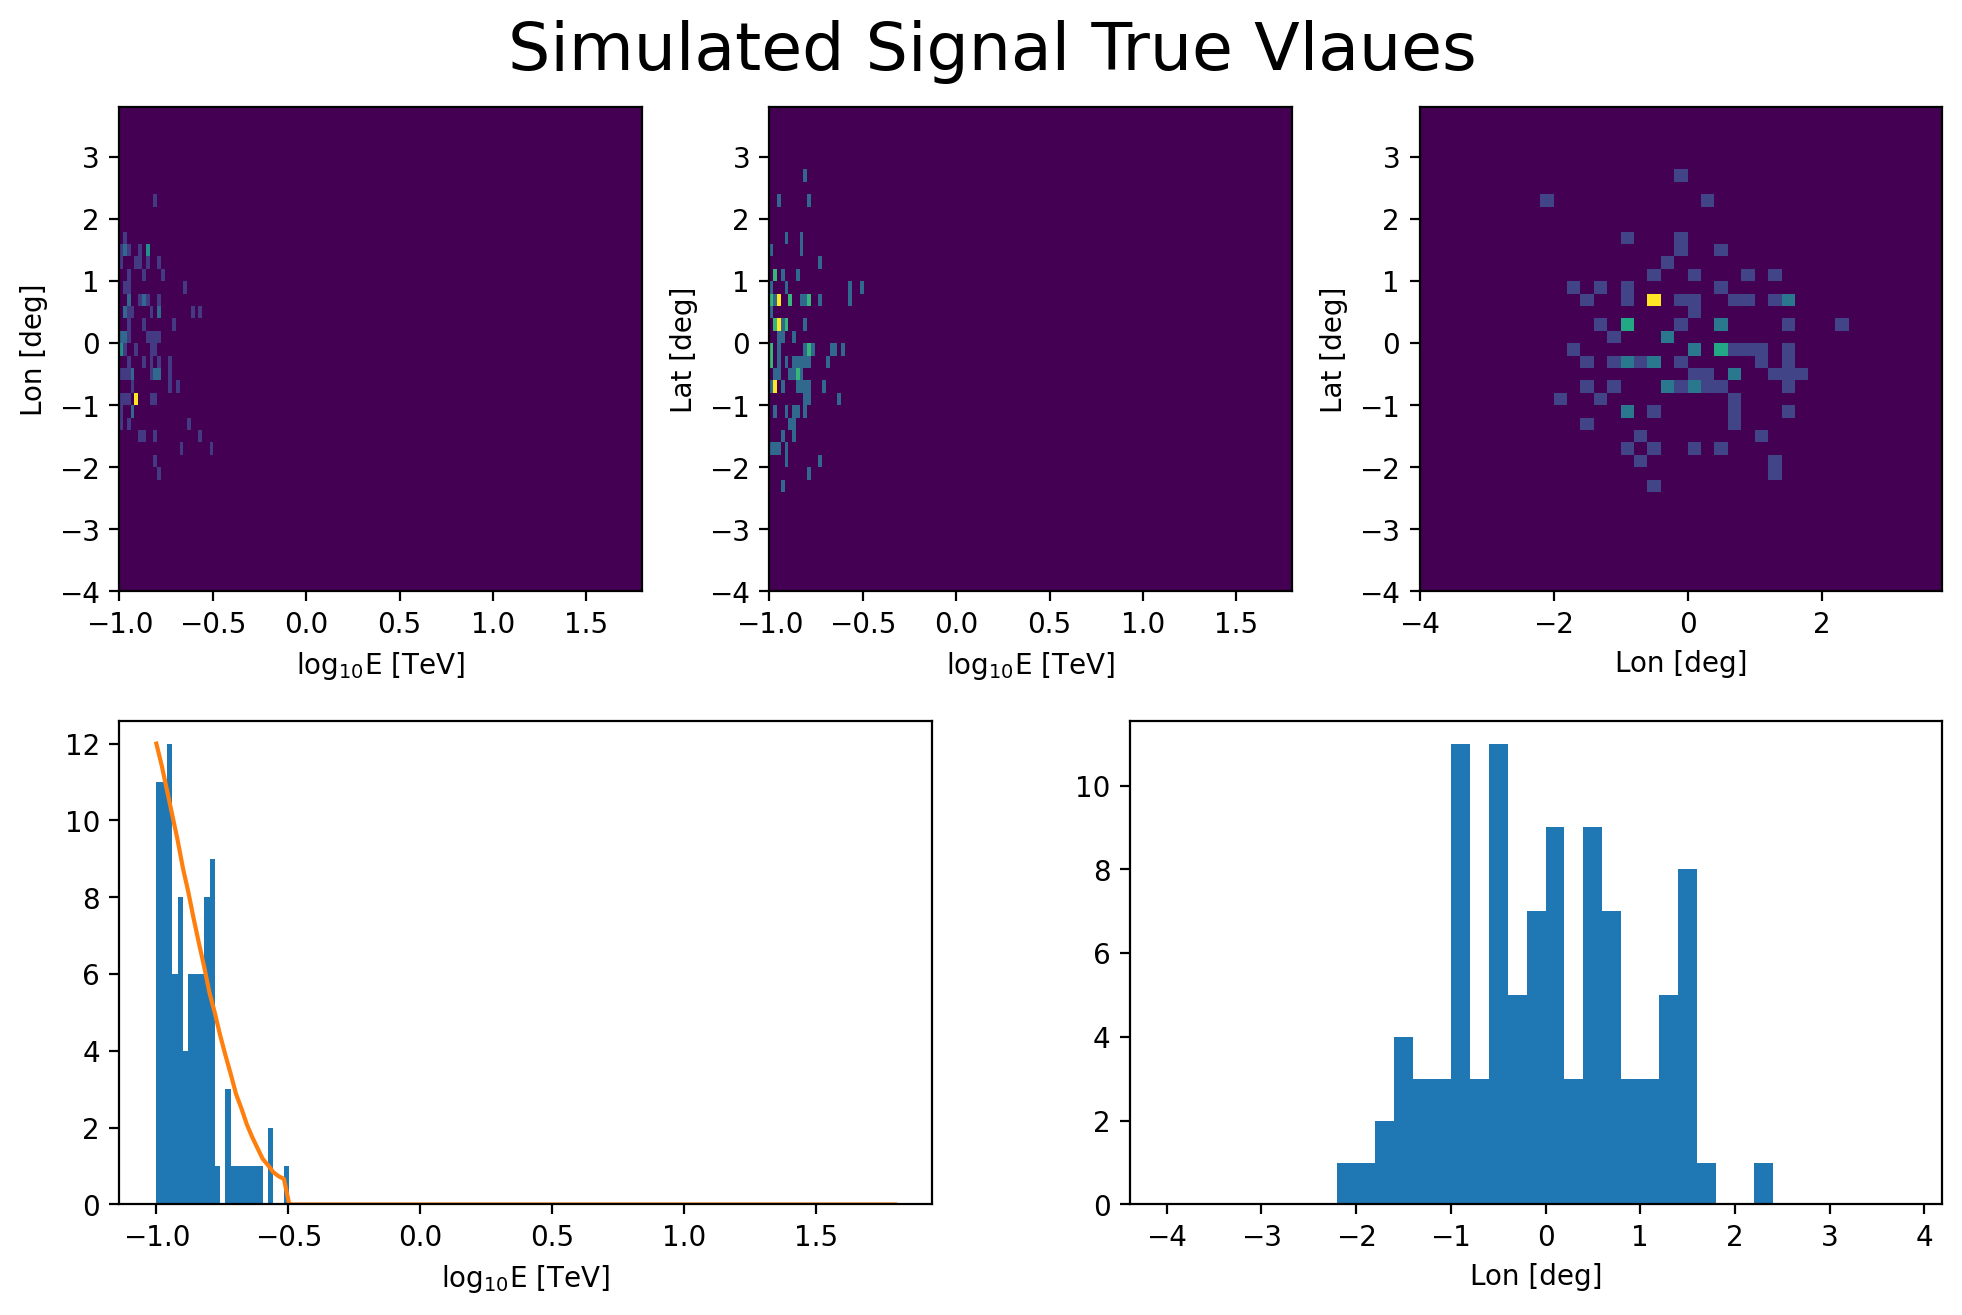

In [15]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(siglogevals, siglonvals, bins=[log10eaxistrue,spatialaxistrue])
plt.ylabel('Lon [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,3,2)
plt.hist2d(siglogevals, siglatvals, bins=[log10eaxistrue,spatialaxistrue])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lat [deg]')



plt.subplot(2,3,3)
plt.hist2d(siglonvals, siglatvals, bins=[spatialaxistrue,spatialaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

print(truelogmassval)
sigspecvals = np.squeeze(np.exp(logjacobtrue+np.squeeze(darkmatterdoubleinput(truelogmassval, log10eaxistrue))))
print(sigspecvals.shape)
plt.subplot(2,2,3)
sigspechistvals = plt.hist(siglogevals, bins=log10eaxistrue)
plt.plot(log10eaxistrue, sigspecvals/np.max(sigspecvals)*np.max(sigspechistvals[0]))
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(siglonvals, bins=spatialaxistrue)
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

plt.suptitle("Simulated Signal True Vlaues", y=1.05, size=24)
plt.show()

In [16]:
bkgresultindices = np.unravel_index(inverse_transform_sampling(flattened_logbkgbinnedprior, Nsamples=nbkg),logbkgbinnedprior.shape)
bkglogevals = log10eaxistrue[bkgresultindices[0]]
bkglonvals = spatialaxistrue[bkgresultindices[1]]
bkglatvals = spatialaxistrue[bkgresultindices[2]]

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/1721193519.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/1721193519.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/1721193519.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


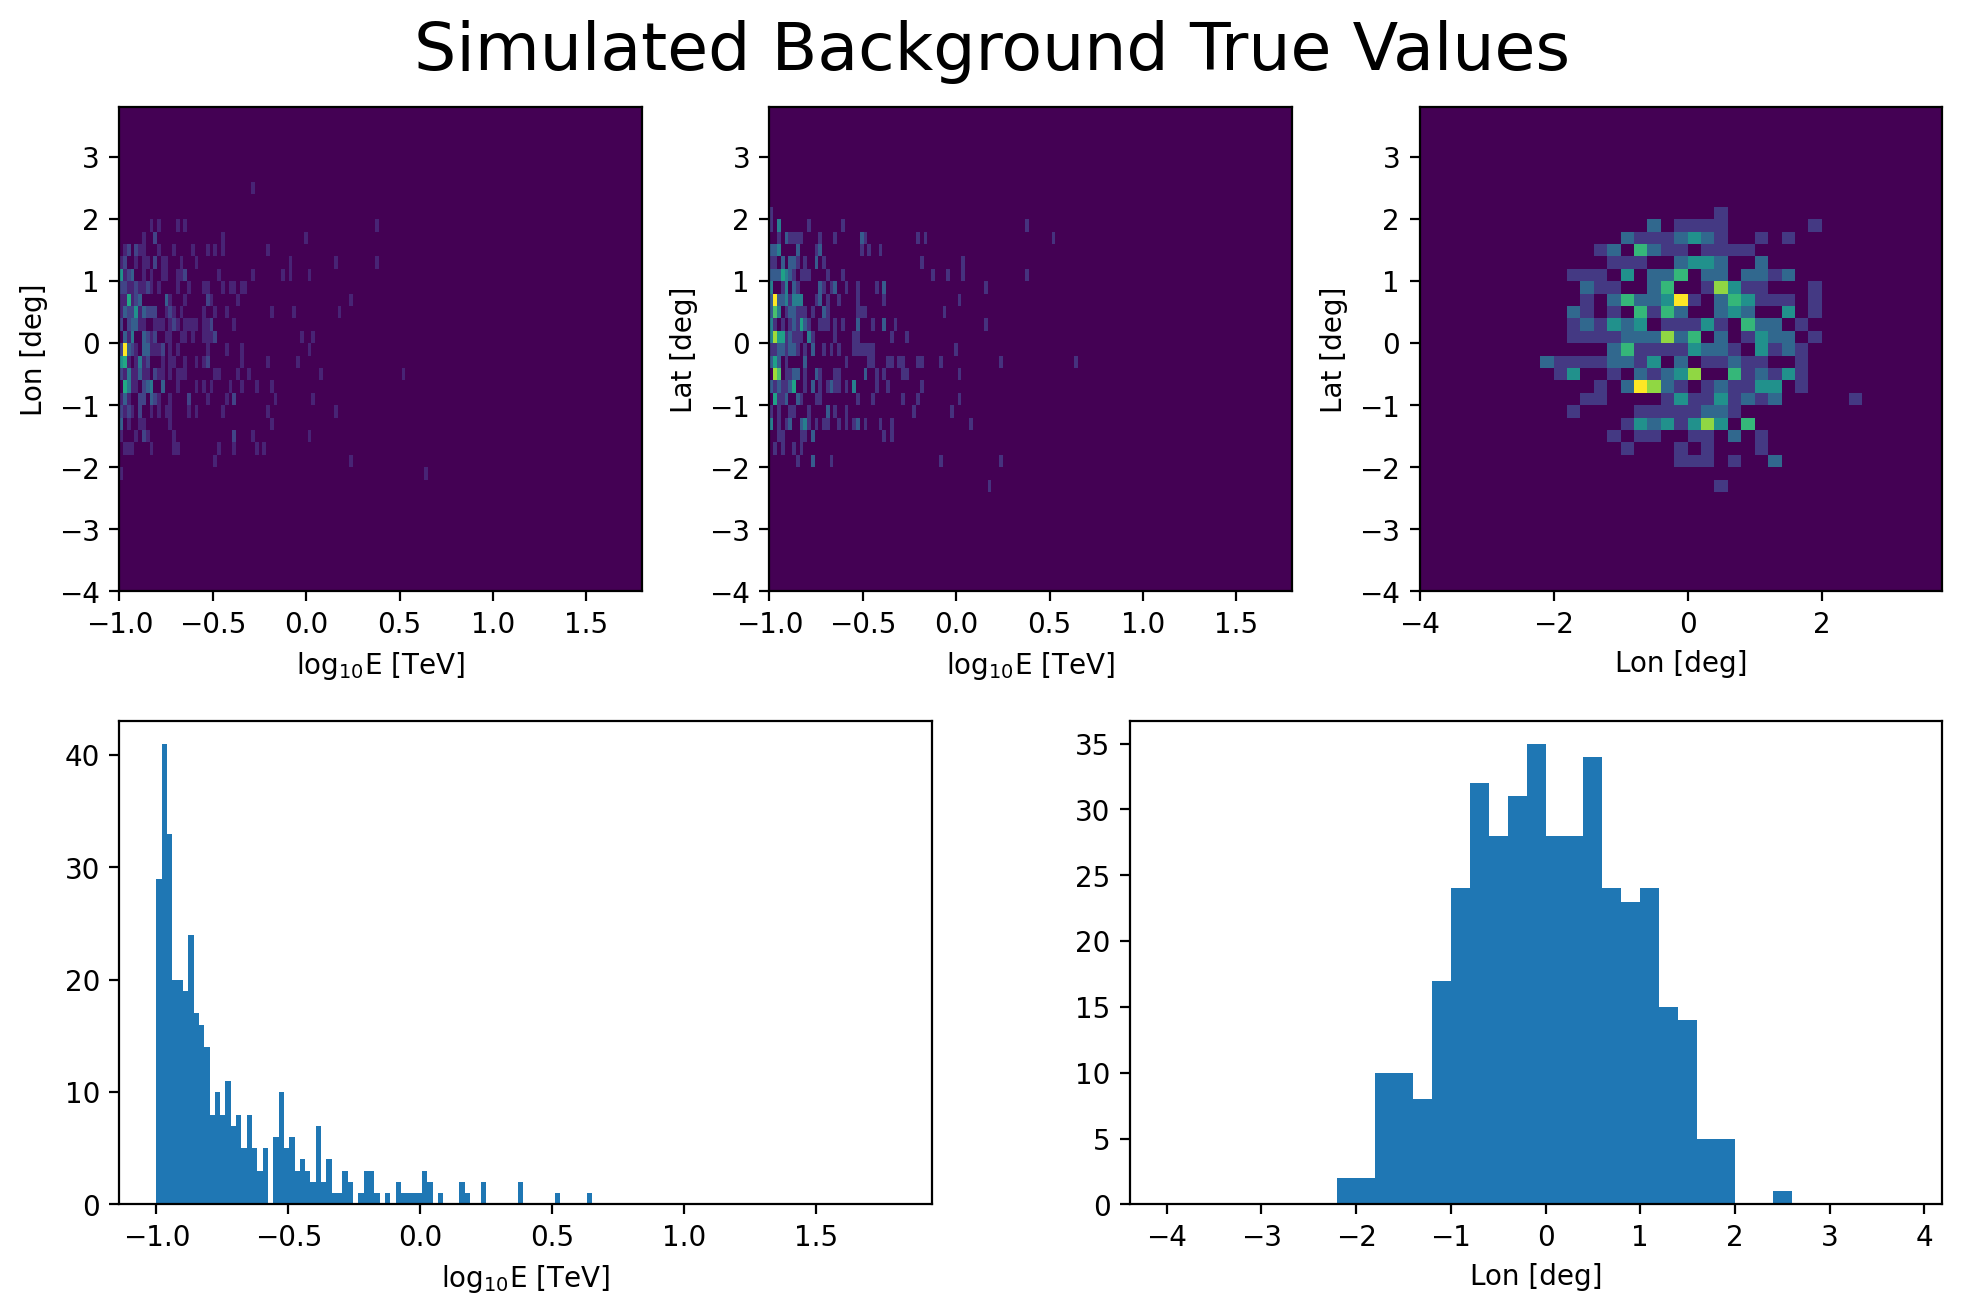

In [17]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkglogevals, bkglonvals, bins=[log10eaxistrue,spatialaxistrue])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(bkglogevals, bkglatvals, bins=[log10eaxistrue,spatialaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(bkglonvals, bkglatvals, bins=[spatialaxistrue,spatialaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(bkglogevals, bins=log10eaxistrue)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(bkglonvals, bins=spatialaxistrue)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Background True Values", y=1.05, size=24)

plt.show()

## Reconstructed Value Simulation

In [18]:
for coord in np.array([siglonvals, siglatvals]).T:
    print(coord)

[ 0.200001   -0.59999919]
[ 0.6000011  -0.19999909]
[-1.59999943 -0.39999914]
[9.53674316e-07 4.00001049e-01]
[ 9.53674316e-07 -5.99999189e-01]
[ 0.200001   -0.79999924]
[-0.59999919 -0.39999914]
[-0.19999909  0.6000011 ]
[-1.79999948  0.80000114]
[0.40000105 0.80000114]
[1.40000129 0.6000011 ]
[ 1.20000124 -0.59999919]
[-0.99999928 -0.39999914]
[2.20000148 0.200001  ]
[ 1.40000129 -0.19999909]
[ 9.53674316e-07 -1.79999948e+00]
[-0.99999928 -1.19999933]
[ 1.00000119 -0.19999909]
[ 0.6000011  -1.39999938]
[-1.59999943  0.6000011 ]
[ 0.40000105 -0.19999909]
[-1.39999938 -0.99999928]
[-1.59999943 -1.39999938]
[-1.79999948 -0.19999909]
[ 9.53674316e-07 -7.99999237e-01]
[-0.59999919 -0.39999914]
[-0.59999919  1.00000119]
[ 0.6000011  -0.59999919]
[0.200001   2.20000148]
[ 0.6000011  -1.19999933]
[-0.59999919  0.6000011 ]
[1.20000124 1.00000119]
[-0.19999909 -0.39999914]
[ 1.00000119 -0.39999914]
[-0.39999914  1.20000124]
[-0.59999919  0.6000011 ]
[-3.99999142e-01  9.53674316e-07]
[-0.199999

### Signal

In [19]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])]

  0%|          | 0/100 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils3d.py:75: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 100/100 [00:00<00:00, 1650.55it/s]


In [20]:
signal_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])
signal_reshaped_indices = np.unravel_index(signal_spatial_indices, shape=lonmeshrecon.shape)
signal_lon_measured = spatialaxis[signal_reshaped_indices[0]]
signal_lat_measured = spatialaxis[signal_reshaped_indices[1]]


100%|██████████| 100/100 [00:00<00:00, 166.14it/s]


In [21]:
spatialaxis.shape

(20,)

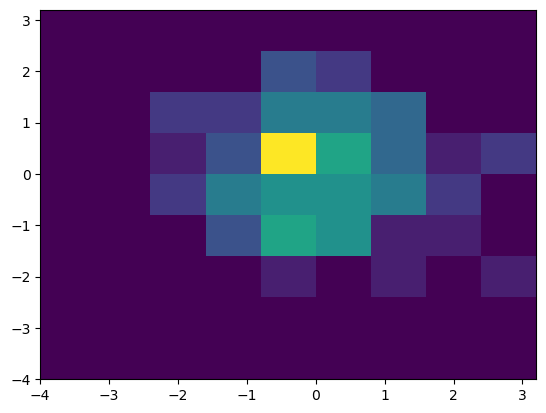

In [22]:
plt.figure()
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=spatialaxis[::2])
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2267594078.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2267594078.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2267594078.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


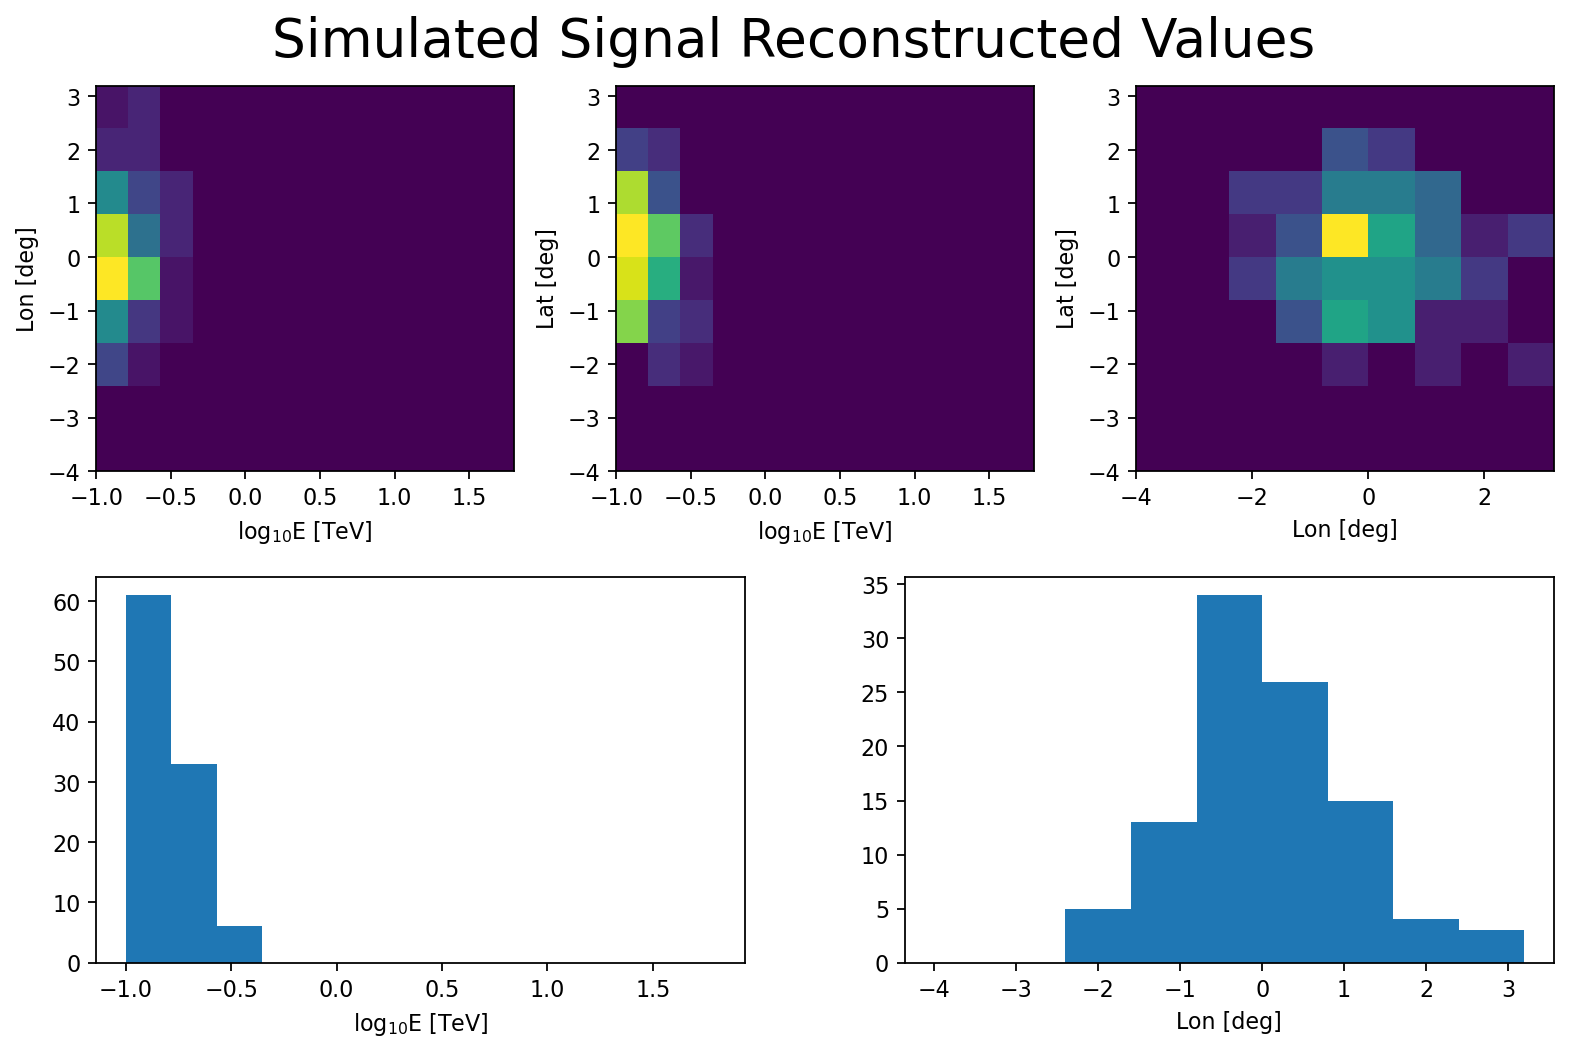

In [23]:
plt.subplots(2,3,dpi=160,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(signal_log10e_measured, signal_lon_measured, bins=[log10eaxis,spatialaxis[::2]])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(signal_log10e_measured, signal_lat_measured, bins=[log10eaxis,spatialaxis[::2]])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=spatialaxis[::2])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(signal_log10e_measured, bins=log10eaxis)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(signal_lon_measured, bins=spatialaxis[::2])
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Signal Reconstructed Values", y=1.05, size=24)

plt.show()

### Background

In [24]:
bkg_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])]

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:00<00:00, 1749.11it/s]


In [25]:
bkg_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])
bkg_reshaped_indices = np.unravel_index(bkg_spatial_indices, shape=lonmeshrecon.shape)
bkg_lon_measured = spatialaxis[bkg_reshaped_indices[0]]
bkg_lat_measured = spatialaxis[bkg_reshaped_indices[1]]


100%|██████████| 400/400 [00:02<00:00, 172.24it/s]


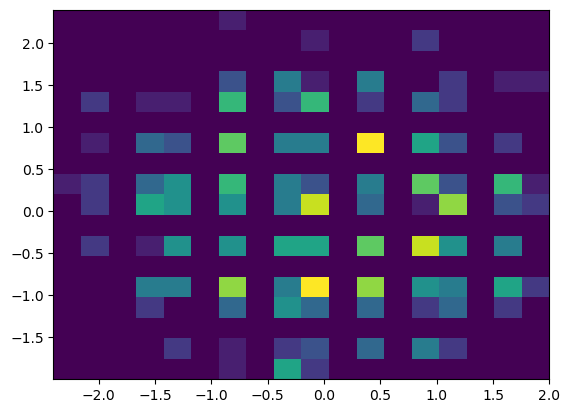

In [26]:
plt.figure()
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[spatialaxis.shape[0]-2, spatialaxis.shape[0]-2])
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2782568003.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2782568003.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2782568003.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


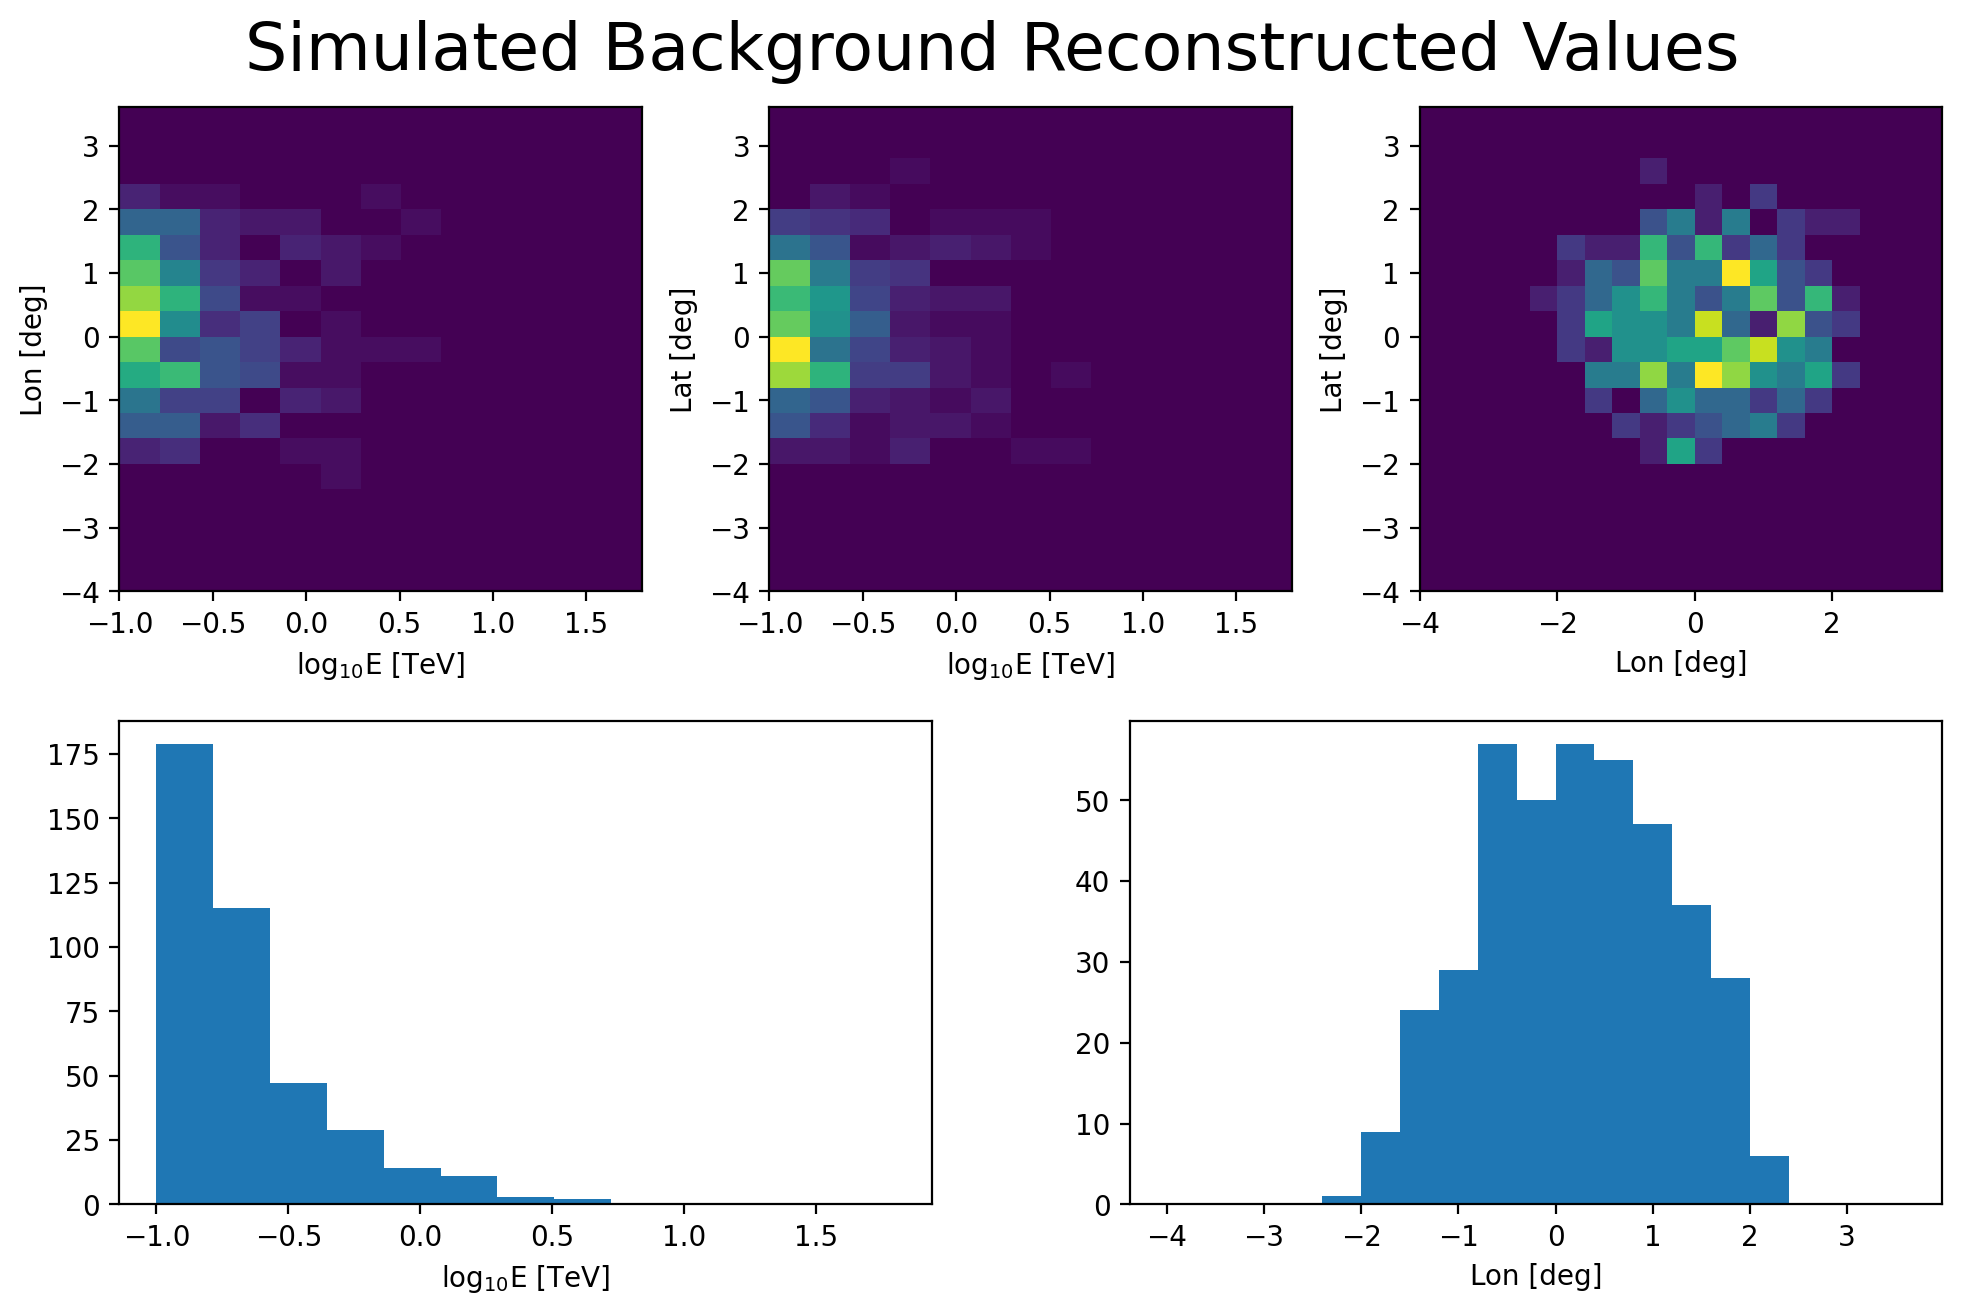

In [27]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkg_log10e_measured, bkg_lon_measured, bins=[log10eaxis,spatialaxis])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(bkg_log10e_measured, bkg_lat_measured, bins=[log10eaxis,spatialaxis])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[spatialaxis,spatialaxis])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(bkg_log10e_measured, bins=log10eaxis)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(bkg_lon_measured, bins=spatialaxis)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Background Reconstructed Values", y=1.05, size=24)

plt.show()

## Final simulation output

In [28]:
measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)

# <h1><b>Analysis

## IRF Normalisation

In [29]:
# lontrue_mesh_psf, logetrue_mesh_psf, lattrue_mesh_psf, lonrecon_mesh_psf, latrecon_mesh_psf = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue, spatialaxis, spatialaxis)

In [30]:
# psfnormalisation = psf(np.array([lonrecon_mesh_psf.flatten(), latrecon_mesh_psf.flatten()]), np.array([lontrue_mesh_psf.flatten(), lattrue_mesh_psf.flatten()]), logetrue_mesh_psf.flatten()).reshape(logetrue_mesh_psf.shape)
# psfnormalisation  = special.logsumexp(psfnormalisation, axis=(-2,-1))
# psfnormalisation.shape

In [31]:
psfnormalisation = np.load('psfnormalisation.npy')

In [32]:
lontrue_mesh_edisp, logetrue_mesh_edisp, lattrue_mesh_edisp, logerecon_mesh_edisp,  = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue, log10eaxis)
lontrue_mesh_edisp.shape

(140, 40, 40, 14)

In [33]:
edispnormalisation = edisp(logerecon_mesh_edisp.flatten(), logetrue_mesh_edisp.flatten(), np.array([lontrue_mesh_edisp.flatten(), lattrue_mesh_edisp.flatten()])).reshape(logetrue_mesh_edisp.shape)
edispnormalisation  = special.logsumexp(edispnormalisation, axis=-1)
edispnormalisation.shape

(140, 40, 40)

In [34]:
edispnormalisation[edispnormalisation==-np.inf] = 0
psfnormalisation[psfnormalisation==-np.inf] = 0

In [35]:
# np.save('psfnormalisation.npy', psfnormalisation)

## IRF Probabilities

In [36]:
lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)

irfproblist = []

for logeval, coord in notebook_tqdm(zip(measured_log10e, np.array([measured_lon, measured_lat]).T), total=len(list(measured_log10e))):
    irfproblist.append(psf(coord, np.array([lontrue_mesh_nuisance.flatten(), lattrue_mesh_nuisance.flatten()]), logetrue_mesh_nuisance.flatten()).reshape(logetrue_mesh_nuisance.shape)+\
        edisp(logeval, logetrue_mesh_nuisance.flatten(), np.array([lontrue_mesh_nuisance.flatten(), lattrue_mesh_nuisance.flatten()])).reshape(logetrue_mesh_nuisance.shape) - edispnormalisation - psfnormalisation)

100%|██████████| 500/500 [01:27<00:00,  5.70it/s]


In [37]:
assert len(irfproblist) == Nsamples
assert irfproblist[0].shape == (log10eaxistrue.shape[0], spatialaxistrue.shape[0],spatialaxistrue.shape[0])

## Signal marginalisation

In [38]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')



numcores                = 10


nbinslogmass            = 101
logmasswindowwidth      = 5/np.sqrt(nsig)


logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth



if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 


In [39]:
tempsigmargfunction = functools.partial(evaluateformass, irfvals=irfproblist, specfunc=signalspecfunc, lontrue_mesh_nuisance=lontrue_mesh_nuisance, logetrue_mesh_nuisance=logetrue_mesh_nuisance, lattrue_mesh_nuisance=lattrue_mesh_nuisance )


signal_log_marginalisationvalues = []


with Pool(numcores) as pool: 
        
    for result in notebook_tqdm(pool.imap(tempsigmargfunction, logmassrange), total=len(list(logmassrange)), ncols=100, desc="Calculating signal marginalisations..."):
            signal_log_marginalisationvalues.append(result)

    pool.close() 

signal_log_marginalisationvalues = np.array(signal_log_marginalisationvalues)
print(signal_log_marginalisationvalues.shape)

Calculating signal marginalisations...:   0%|                               | 0/101 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/BFCalc/createspectragrids.py:108: RuntimeWarning: divide by zero encountered in log
  return np.log(twodinterpolationfunc(logmDM, logenergy-logmDM))
Calculating signal marginalisations...:   1%|▏                      | 1/101 [00:04<06:58,  4.18s/it]/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(e

(101, 500)


## Background Marginalisation

In [40]:
bkgpriorarray  = bkgdist(logetrue_mesh_nuisance, lontrue_mesh_nuisance, lattrue_mesh_nuisance)
bkgpriorarray = bkgpriorarray - special.logsumexp(bkgpriorarray.T+logjacobtrue)

bkgmargvals = [special.logsumexp(bkgpriorarray.T+irfarray.T+logjacobtrue) for irfarray in irfproblist]
bkgmargvals = np.array(bkgmargvals)
print(bkgmargvals.shape)

(500,)


## Calculating posterior

In [41]:
log_logmassposterior = [np.sum(np.logaddexp(np.log(truelambda)+signal_log_marginalisationvalues[logmassindex,:], np.log(1-truelambda)+bkgmargvals)) for logmassindex in range(len(list(logmassrange)))]

log_logmassposterior = np.array(log_logmassposterior)-special.logsumexp(log_logmassposterior)


log_logmassposterior.shape

(101,)

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_19337/2865253653.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 5)


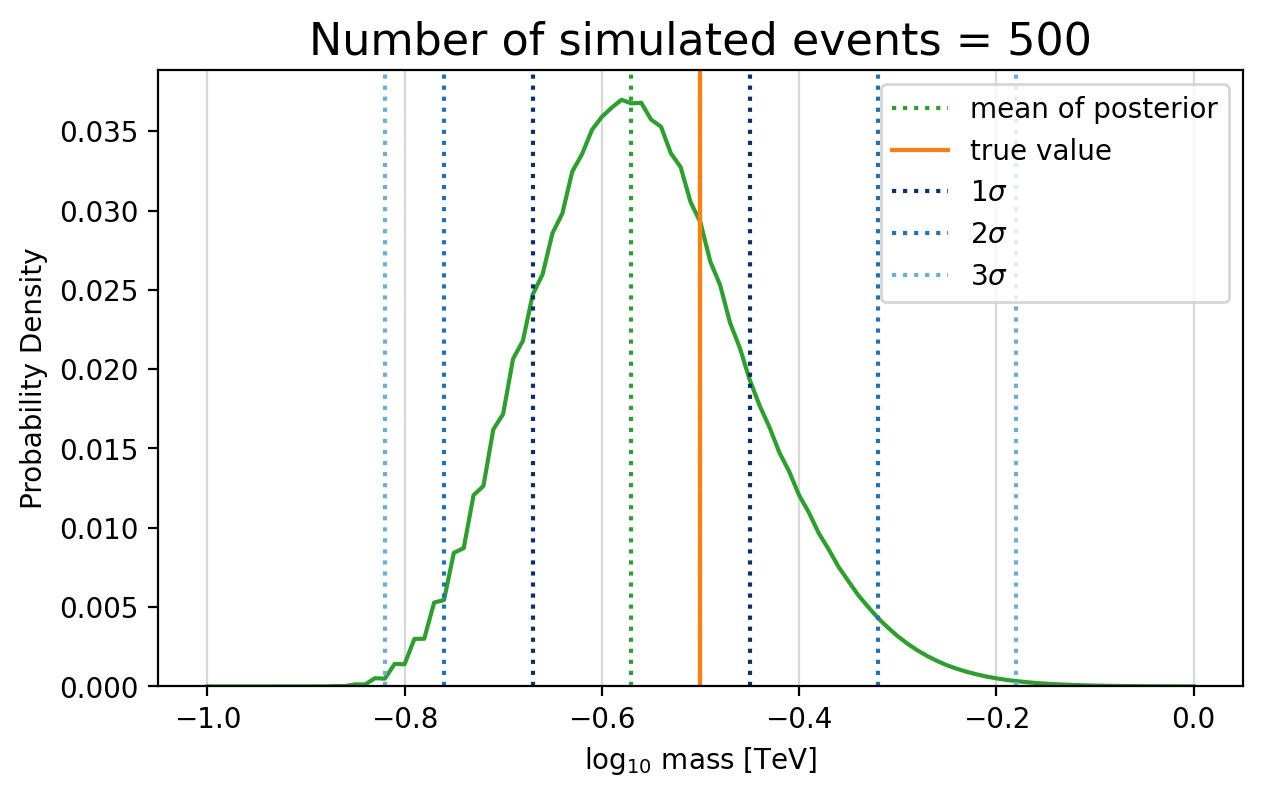

In [42]:
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 5)

logmassposterior = np.exp(log_logmassposterior)

cdflogmassposterior = np.cumsum(logmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])




plt.figure(dpi=200, figsize=(7,4))


plt.title(f"Number of simulated events = {Nsamples}", size=16)
plt.xlabel(r"log$_{10}$ mass [TeV]")
plt.ylabel("Probability Density [1/TeV]")
plt.plot(logmassrange, np.exp(log_logmassposterior), c='tab:green')
plt.axvline(mean, c='tab:green', ls=':', label="mean of posterior")
plt.axvline(truelogmassval, c="tab:orange", label="true value")


for o, percentile in enumerate(logmasspercentiles):
            color = colormap((np.abs(zscores[o]))/5-0.1)
            if o<3:
                plt.axvline(percentile, c=color, ls=':')
            else:
                plt.axvline(percentile, c=color, ls=':', label=f"{zscores[o]}"+r"$\sigma$")
plt.axvline(truelogmassval, ls='--', color="tab:orange")
plt.grid(axis='x', markevery=log10eaxistrue, alpha=0.5)
plt.ylabel('Probability Density')
plt.ylim([0, None])

plt.legend()
# plt.savefig("Figures/TestFigures/firstsuccessful10000_3dinput_logmass.pdf")
plt.show()